# Introduction


汽车需要能够轻松转弯，改变车道，在红灯处停车等。因为汽车能够使用其传感器的信息准确地识别3D空间中的物体，例如图像和LiDAR数据。

- 我将解释数据集中每个组件（包括图像，[LiDAR](https://en.wikipedia.org/wiki/Lidar)和点云）背后的含义和理解。 
- 我将展示如何将此数据集打包为紧凑格式，从而使从数据集中查询信息更加容易。
- 最后，我将展示如何使用**plotly,matplotlib**中的图表可视化和探索这些数据。

# Data

- `scene` 范围在25-45之间，代表每一个环境中都有一辆汽车行驶25-45秒的数据
- `sample_data` 指定每一时刻一帧图片的数据，其中也有该帧中所有被标记的目标（人，车，自行车，卡车等）
- `category` 被标记的目标分类（人，汽车，自行车，卡车）

图片数据中的每一帧均包含两种形式的信息: **image data and LiDAR data**.

图像数据采用通常的*.jpeg*格式，这很容易理解。 每个图像仅包含三个颜色通道：形成RGB彩色图像格式的红色（R），蓝色（B）和绿色（G）这些颜色通道叠加形成最终的彩色图像。 

因此，四维张量：**（batch_size，channels，width，height）**。

# What is LiDAR?

LiDAR（光检测和测距）是一种用于生成周围环境的准确3D表示的方法，并且它使用激光来实现此目的。

基本上，3D目标是用激光（聚焦的定向光束）照射的，反射光是由传感器收集的。计算出光反射回传感器所需的时间。

**不同的传感器从物体的不同部分收集光，并且传感器记录的时间会有所不同。由传感器计算出的时间差可用于计算物体的深度。结合了图像的2D表示的深度信息可提供对象的准确3D表示。此过程类似于实际的人类视觉。两只眼睛以2D进行观察，并将这两条信息组合在一起以形成3D地图（深度感知）。这就是人类对我们周围世界的感觉**。


# Visualizing the data

In [1]:
!pip install lyft_dataset_sdk
!pip install pyquaternion

     |████████████████████████████████| 102kB 5.3MB/s ta 0:00:011
     |████████████████████████████████| 81kB 6.5MB/s eta 0:00:011
     |████████████████████████████████| 747kB 6.6MB/s eta 0:00:01
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111003 sha256=5efa504855c9a253a47051d02f124bc80f689219edcf90d5cbcedd018dd928e4
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire
  Found existing installation: typed-ast 1.3.4
    Uninstalling typed-ast-1.3.4:
      Successfully uninstalled typed-ast-1.3.4


Now, I will import the other libraries necessary to carry out the exploration.

In [2]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

In [3]:
DATA_PATH = '../input/3d-object-detection-for-autonomous-vehicles/'

In [4]:
train = pd.read_csv(DATA_PATH + 'train.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

print(train.head())

                                                  Id  \
0  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...   
1  edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...   
2  1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...   
3  a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...   
4  b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...   

                                    PredictionString  
0  2680.2830359778527 698.1969292852777 -18.04776...  
1  1208.642684768659 1585.1812946970927 -23.56236...  
2  848.9346793681768 2587.2870557176507 -20.15995...  
3  1994.4320280494098 1128.30164336183 -18.054752...  
4  1030.3877156973385 1667.13131694941 -23.764820...  


1. ### 按照object类别进行分类

In [5]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:03<00:00, 7248.23it/s]


### 将数据类型从str转换为float32

In [7]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [8]:
train_objects.head()

sample_id  object_id     center_x  \
0  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        0.0  2680.282959   
1  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        1.0  2691.997559   
2  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        2.0  2713.607422   
3  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        3.0  2679.986816   
4  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        4.0  2659.352051   

     center_y   center_z  width  length  height       yaw class_name  
0  698.196899 -18.047768  2.064   5.488   2.053  2.604164        car  
1  660.801636 -18.674259  1.818   4.570   1.608 -0.335176        car  
2  694.403503 -18.589972  1.779   4.992   1.620  2.579456        car  
3  706.910156 -18.349594  1.798   3.903   1.722  2.586166        car  
4  719.417480 -18.442999  1.936   4.427   1.921  2.601799        car

### center_x and center_y
“**center_x**”和“**center_y**”对应于对象位置（边界体积）的中心的“x”坐标和“ y”坐标。 这些坐标表示对象在**x-y**平面上的位置。

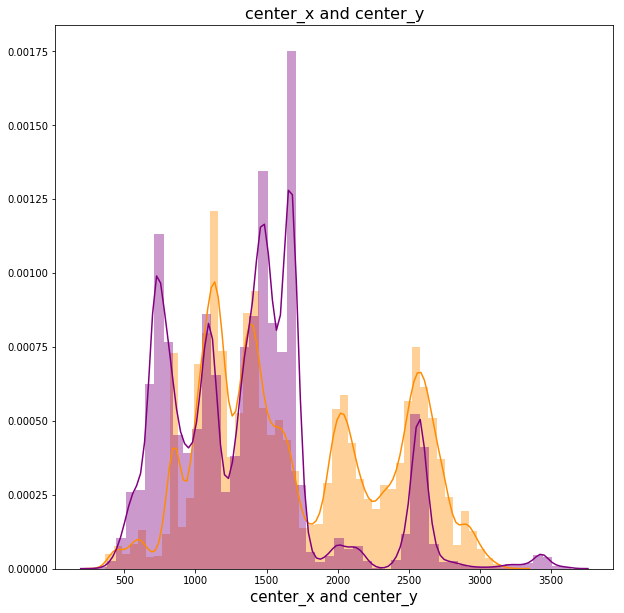

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_x'], color='darkorange', ax=ax).set_title('center_x and center_y', fontsize=16)
sns.distplot(train_objects['center_y'], color='purple', ax=ax).set_title('center_x and center_y', fontsize=16)
plt.xlabel('center_x and center_y', fontsize=15)
plt.show()

在上图中，紫色分布为**center_y**，橙色分布为**center_x**。从上图中，我们可以看到**center_x**和**center_y**的分布都有多个峰，因此是多峰的。两种分布都具有明显的向右或正偏斜。但是，**center_y**（紫色）的分布比**center_x**（橙色）的分布明显偏高。 **center_x**分布更均匀地分布。

这表明对象沿**x轴**非常均匀地散布，但不沿**y轴**均匀地散布。这可能是因为道路宽度小，汽车的摄像头可以轻松感应左右对象（沿**x轴**）。但是，由于道路的长度远大于道路的宽度，并且从该角度挡住摄像机视野的可能性更大，因此摄像机只能找到狭窄的物体或狭窄的物体（而不是更远的物体）。

### center_z

center_z对应于对象位置（边界体积）中心的**z**坐标。该坐标表示对象在**x-y**平面上方的高度。

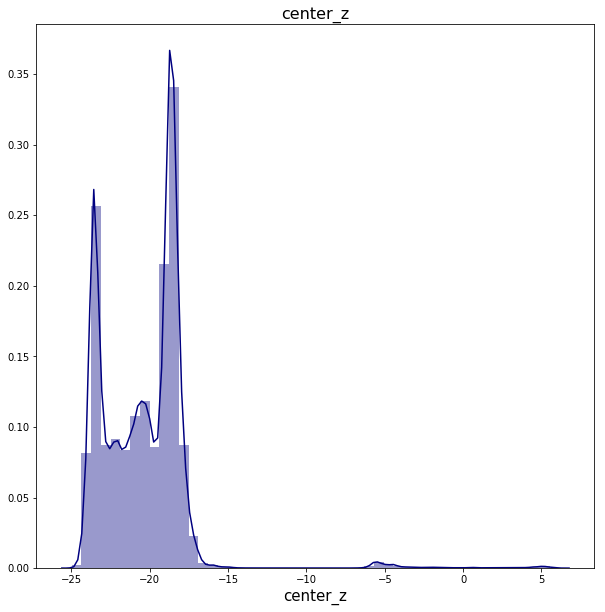

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_z'], color='navy', ax=ax).set_title('center_z', fontsize=16)
plt.xlabel('center_z', fontsize=15)
plt.show()

在上图中，我们可以看到**center_z**的分布具有极高的正（向右）偏斜，并且聚集在-20标记附近（近似于其平均值）。 

- **center_z**的变化（扩展）显着小于**center_x**和**center_y**的变化。 
这可能是因为大多数对象都非常靠近道路的平面，因此，在摄像机上方（或下方）的对象的高度没有太大变化。 

- 由于相机安装在汽车的顶部，因此大多数*z*坐标均为负。 因此，在大多数情况下，相机必须“向下看”才能看到物体。 
- 因此，物体相对于相机的高度或z坐标通常为负。

### width

宽度只是对象所在边界体积的宽度。

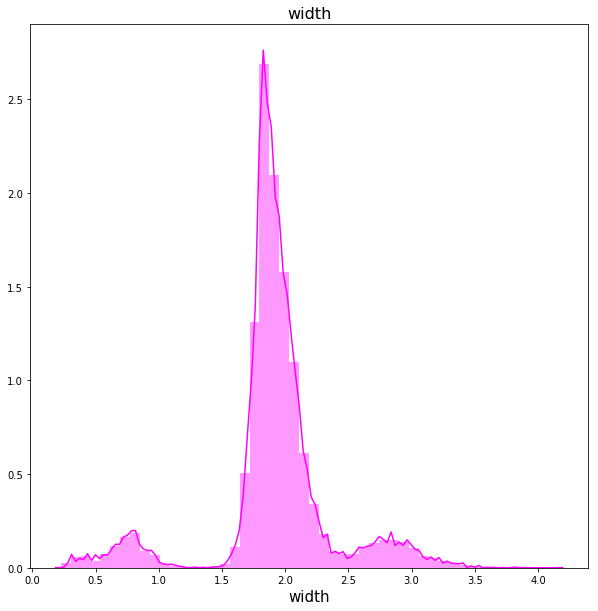

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['width'], color='magenta', ax=ax).set_title('width', fontsize=16)
plt.xlabel('width', fontsize=15)
plt.show()

在上图中
- 我们可以看到width大约正态分布，平均值大约为2，左右各有一些离群值。

- 大多数物体是汽车（我们将在后面看到），它们的宽度约为2（在峰值处）。 
- 右侧的异常值代表较大的对象，例如卡车和货车
- 左侧的异常值表示较小的对象，例如行人和自行车。

### length

**length**只是对象所在边界体积的长度。

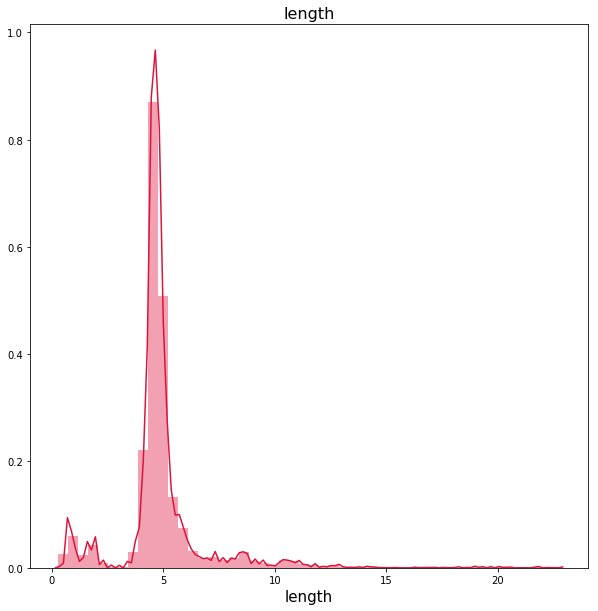

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['length'], color='crimson', ax=ax).set_title('length', fontsize=16)
plt.xlabel('length', fontsize=15)
plt.show()

在上图中
- 我们可以看到**length**的分布具有很强的正向（右偏）分布，均值约为5，并且在任一侧都有异常值。 
- 大部分物体是汽车（我们将在后面看到），它们的长度约为5（在高峰时）。 
- 右侧的异常值代表较大的对象，例如卡车和货车
- 左侧的异常值表示较小的对象，例如行人和自行车。

### height

**height**只是对象所在边界体积的高度。

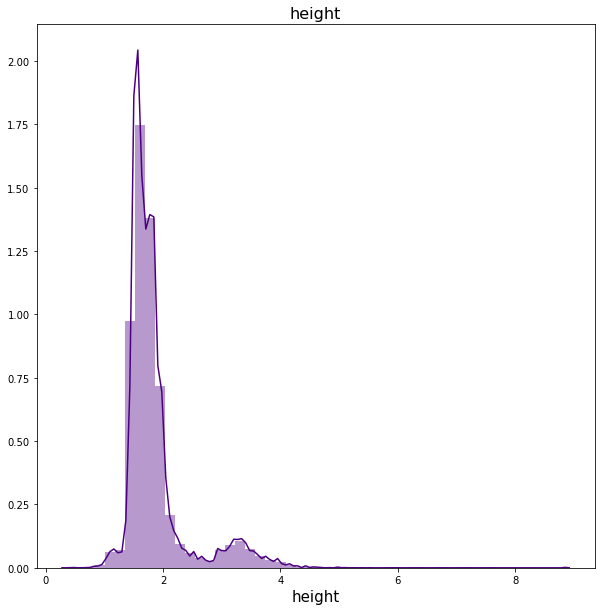

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['height'], color='indigo', ax=ax).set_title('height', fontsize=16)
plt.xlabel('height', fontsize=15)
plt.show()

在上图中，
- 我们可以看到**height**的分布具有很强的正向（向右偏斜）分布，均值约为2，两侧都有一些离群值。 
- 大部分物体是汽车（我们将在后面看到），它们的长度约为2（在峰值处）。 
- 右侧的异常值代表较大的对象，例如卡车和货车
- 左侧的异常值表示较小的对象，例如行人和自行车。

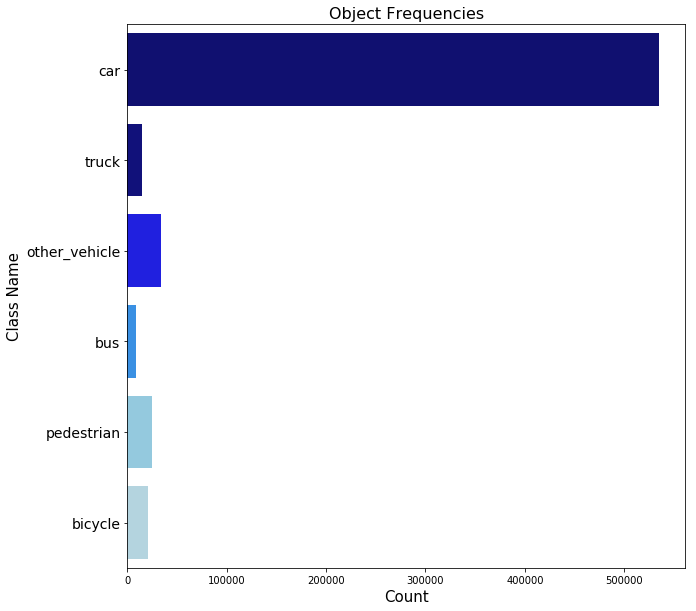

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="class_name", data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue']).set_title('Object Frequencies', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Class Name", fontsize=15)
plt.show(plot)

从上图可以看出
- 数据集中最常见的对象类是“汽车”，在这些道路上可见的最常见的车辆（或与此相关的实体）是汽车。

### center_x *vs.* class_name

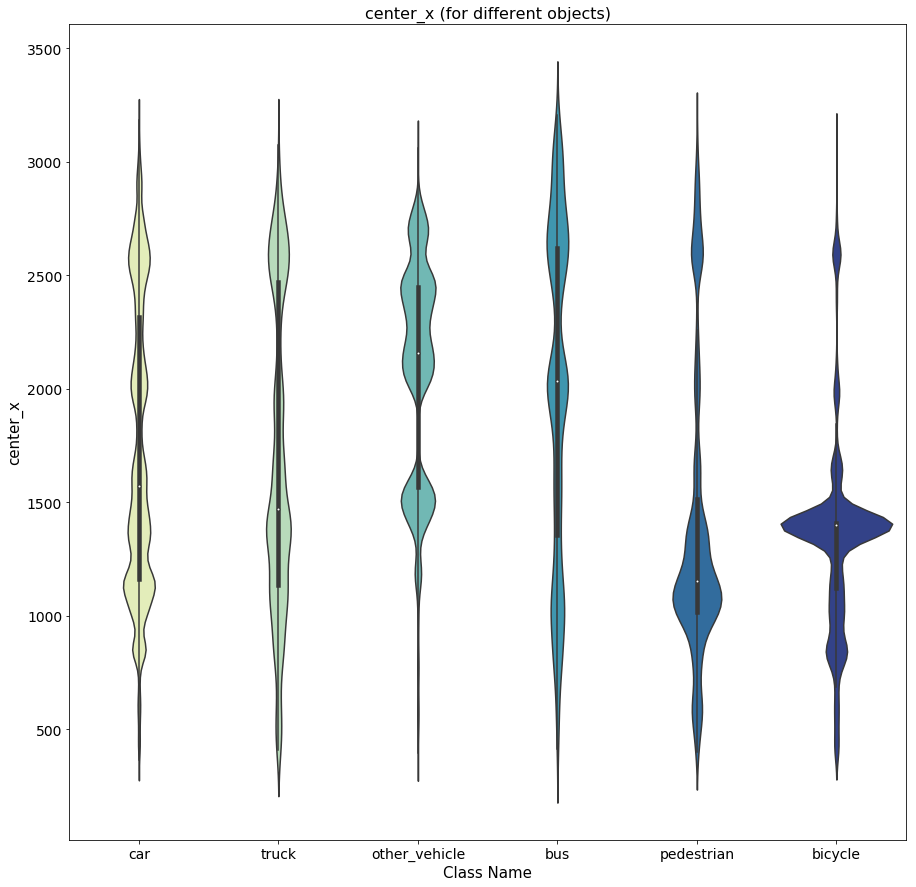

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="center_x",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                      palette='YlGnBu',
                      split=True, ax=ax).set_title('center_x (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_x", fontsize=15)
plt.show(plot)

在上面的小提琴图中，我们可以看到
- 包括卡车，公共汽车和其他车辆在内的大型车辆的*center_x*分布很均匀
- 这可能是因为这些大型车辆倾向于与其他车辆保持更大的距离
- 并且较小的车辆不会与这些大型车辆保持太近的距离以避免发生事故。
- 因此，对于大型车辆（例如公共汽车和卡车），平均值*center_x*显然更大。


- 较小的物体（如行人和自行车）具有*center_x*分布，具有强烈的正（向右）偏斜。
- 这些分布的均值也明显低于大型车辆的分布。
- 这可能是因为行人（骑行者）和骑自行车的人不需要与汽车和卡车保持较大距离来避免发生事故。当交通暂停时，他们通常会在红色交通信号灯时过马路。

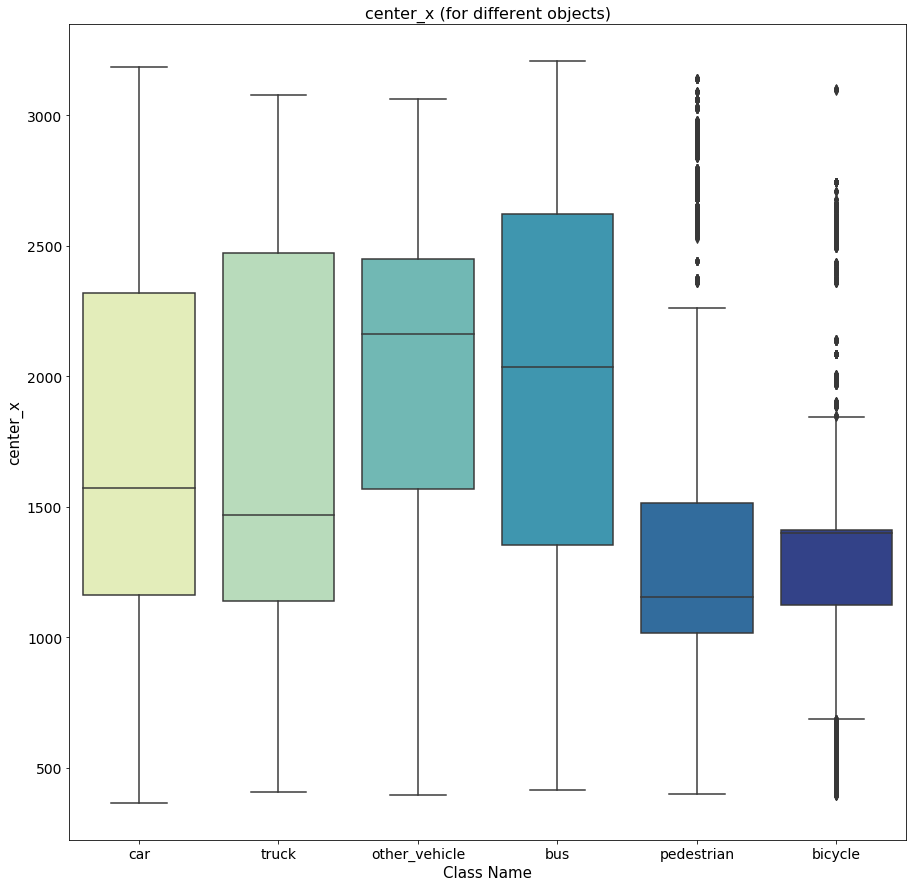

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_x",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGnBu', ax=ax).set_title('center_x (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_x", fontsize=15)
plt.show(plot)

- 在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。 
- 与汽车，卡车和公共汽车等较大物体相比，行人和自行车等较小物体的**center_x**分布具有很低的均值和四分位数。

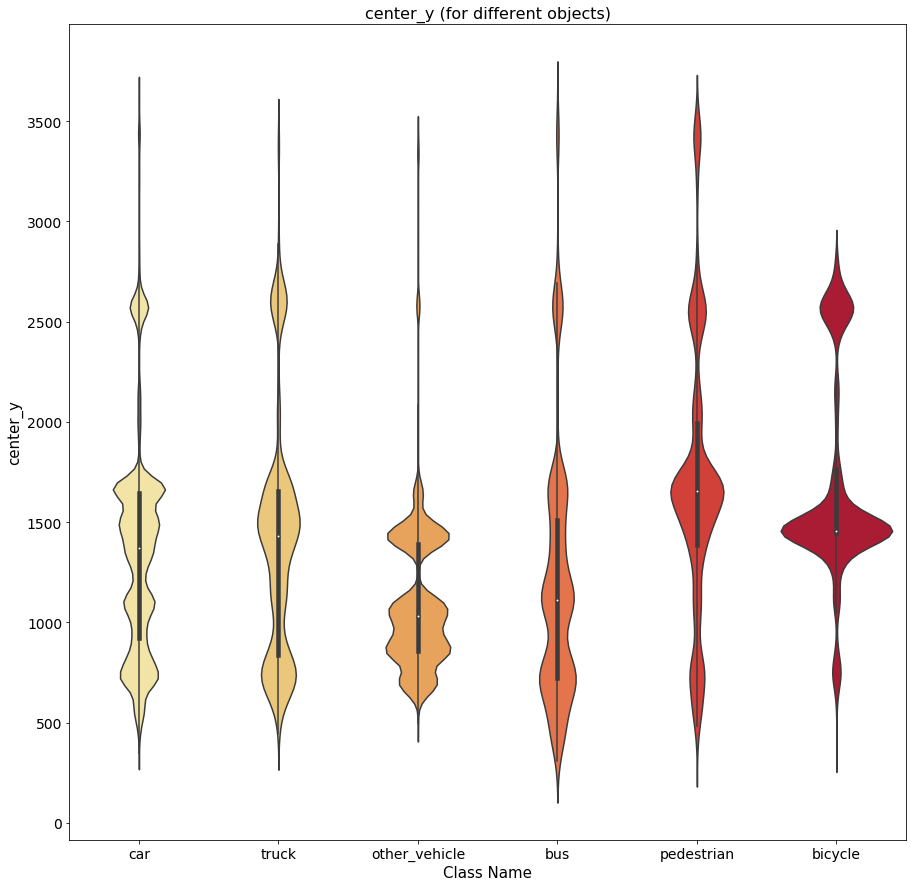

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="center_y",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                      palette='YlOrRd',
                      split=True, ax=ax).set_title('center_y (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_y", fontsize=15)
plt.show(plot)

在上面的小提琴图中，我们可以看到
- 包括行人和自行车在内的小物体的**center_y**分布具有比卡车和公共汽车等大物体更大的平均值。
- 与大型对象相比，小型对象的分布具有更高的概率密度，集中在**center_y**的较高值处。
- 这表示一般而言，小对象比大对象具有更大的**center_y**值。

- 这可能是因为大型车辆因其较大的尺寸而倾向于位于相机的视场内。
- 自行车和行人等较小的物体如果距离太近，就不能留在相机的视野中。
- 因此，大多数被检测到的人行横道和自行车往往距离很远。
- 与大对象相比，这导致小对象的**center_y**更大（平均）。

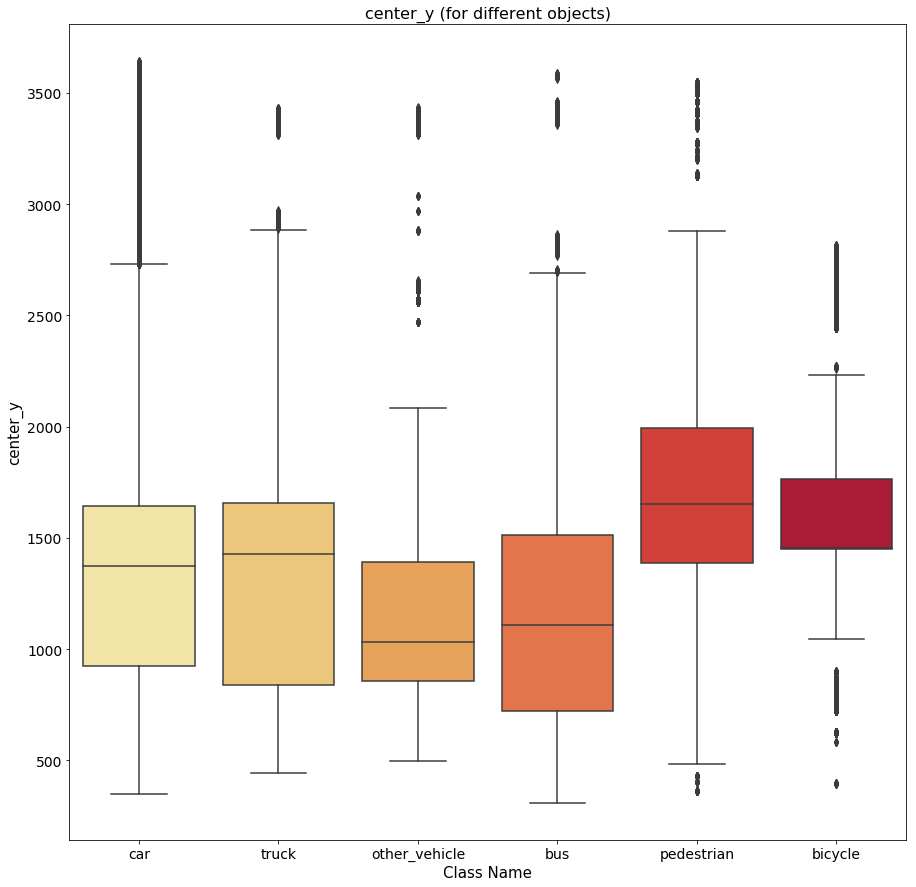

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_y",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlOrRd', ax=ax).set_title('center_y (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_y", fontsize=15)
plt.show(plot)

在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。
- 与较大的对象（例如汽车，卡车和公共汽车）相比，行人和自行车等较小的对象的**center_y**分布具有更大的均值和四分位值。

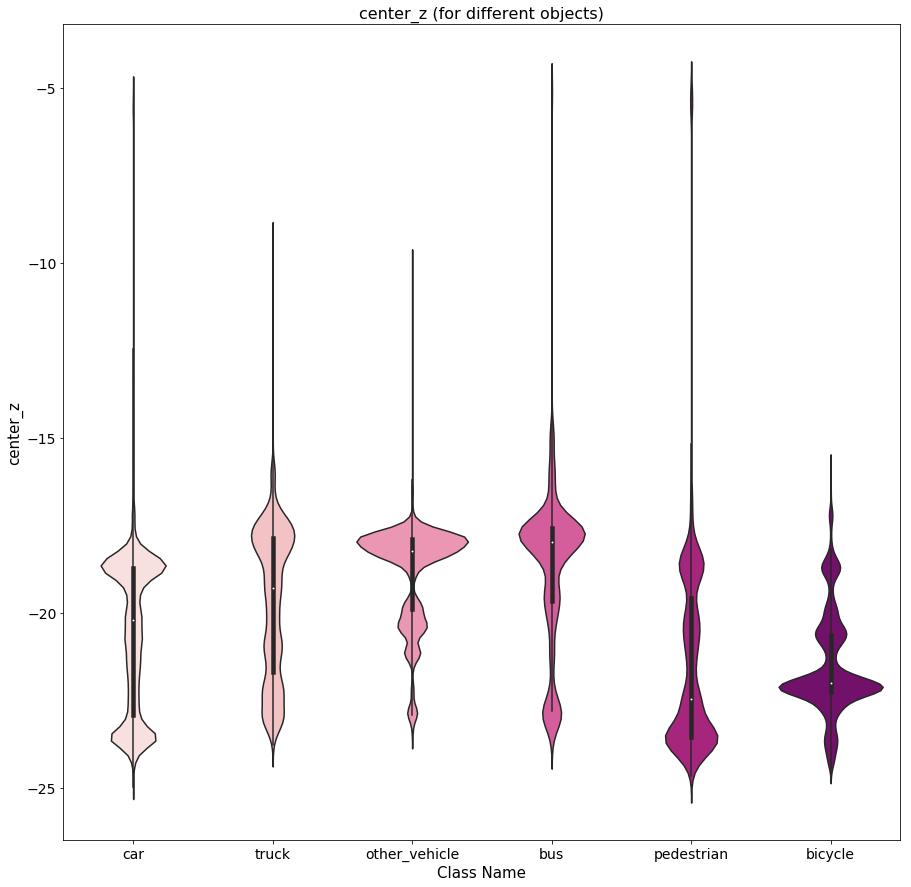

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="center_z",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"').query('center_z <= -5'),
                      palette='RdPu',
                      split=True, ax=ax).set_title('center_z (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_z", fontsize=15)
plt.show(plot)

在上面的小提琴图中，我们可以看到，小物体（包括行人和自行车）的**center_z**分布的均值比卡车和公共汽车等大物体的平均值小得多。
与大对象相比，小对象的分布具有更大的概率密度，集中在**center_z**的较低值处。
这表示一般而言，小对象的**center_y**值小于大对象。


- 这可能是因为行人和自行车等较小的物体往往具有较低的高度（相对于摄像机而言）。 
- 并且，另一方面，较大的物体，例如汽车，卡车和公共汽车，相对于相机而言具有更高的高度。

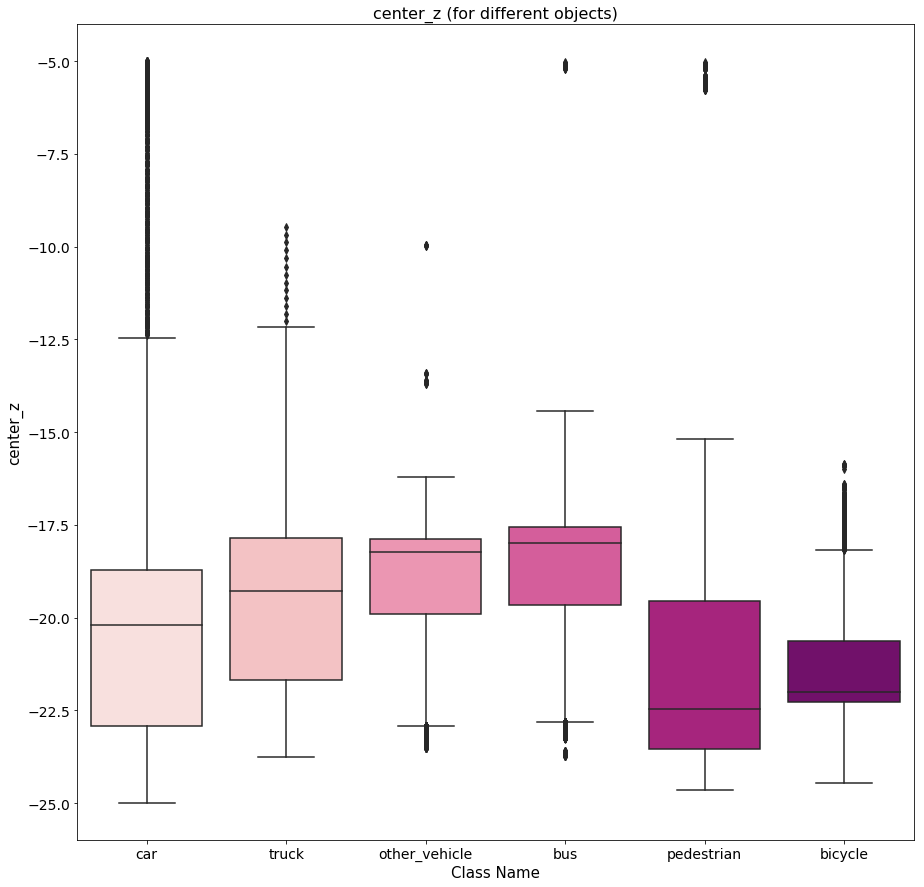

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_z",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"').query('center_z <= -5'),
                   palette='RdPu', ax=ax).set_title('center_z (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_z", fontsize=15)
plt.show(plot)

在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。
与较大的对象（如汽车，卡车和公共汽车）相比，行人和自行车等较小对象的**center_z**分布的均值和四分位数值要小得多。

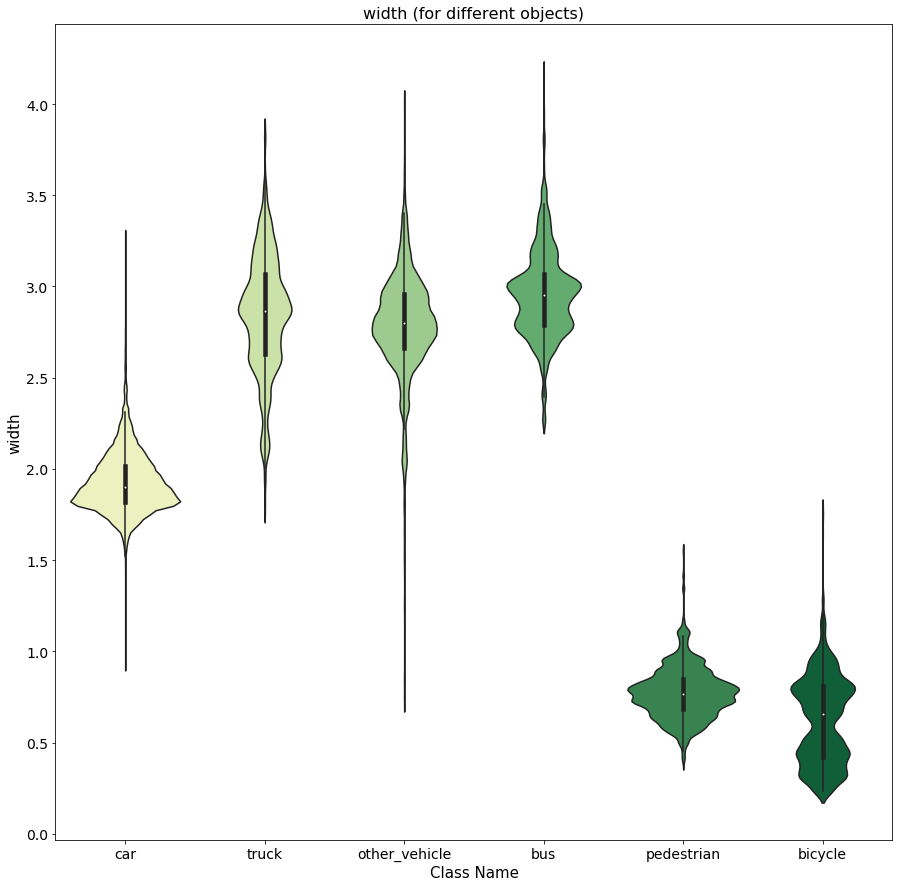

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="width",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                      palette='YlGn',
                      split=True, ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

在小提琴图中
- 我们可以清楚地看到，与行人和自行车等小型物体相比，大型汽车（如汽车，公共汽车和卡车）的*width*分布具有更大的均值。
- 因为卡车，公共汽车和小汽车的宽度几乎总是比行人和自行车大得多。

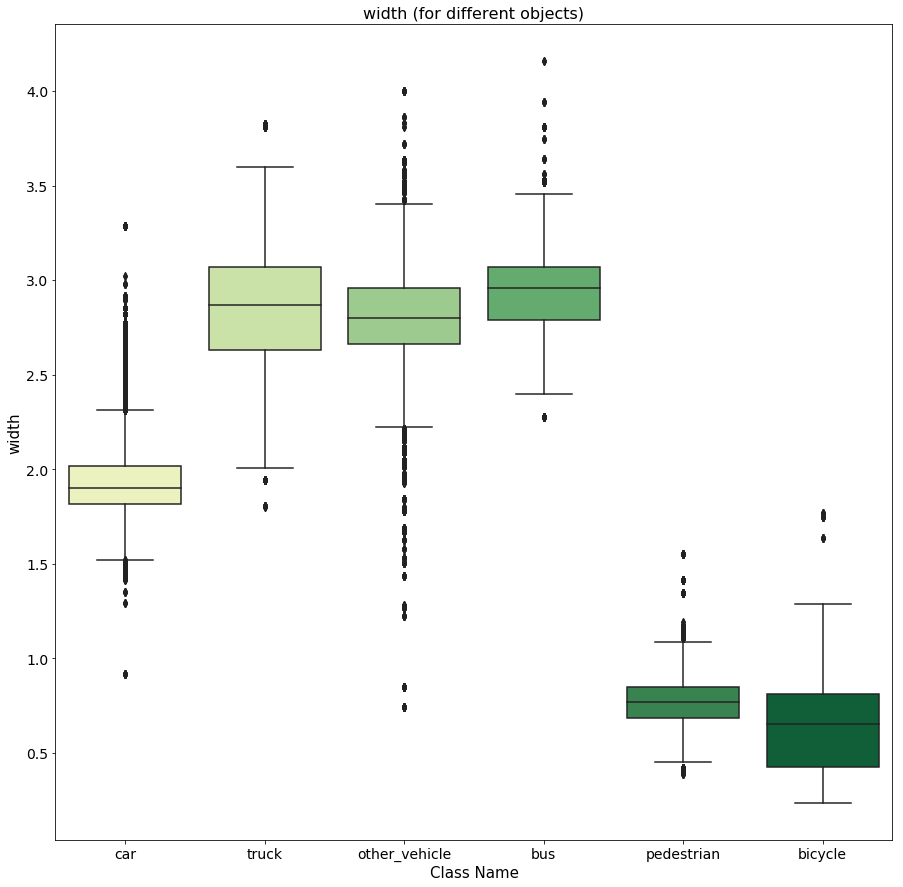

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="width",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGn', ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。 
- 与较大的物体（如汽车，卡车和公共汽车）相比，行人和自行车等较小的物体的“宽度”分布具有较小的均值和四分位数。

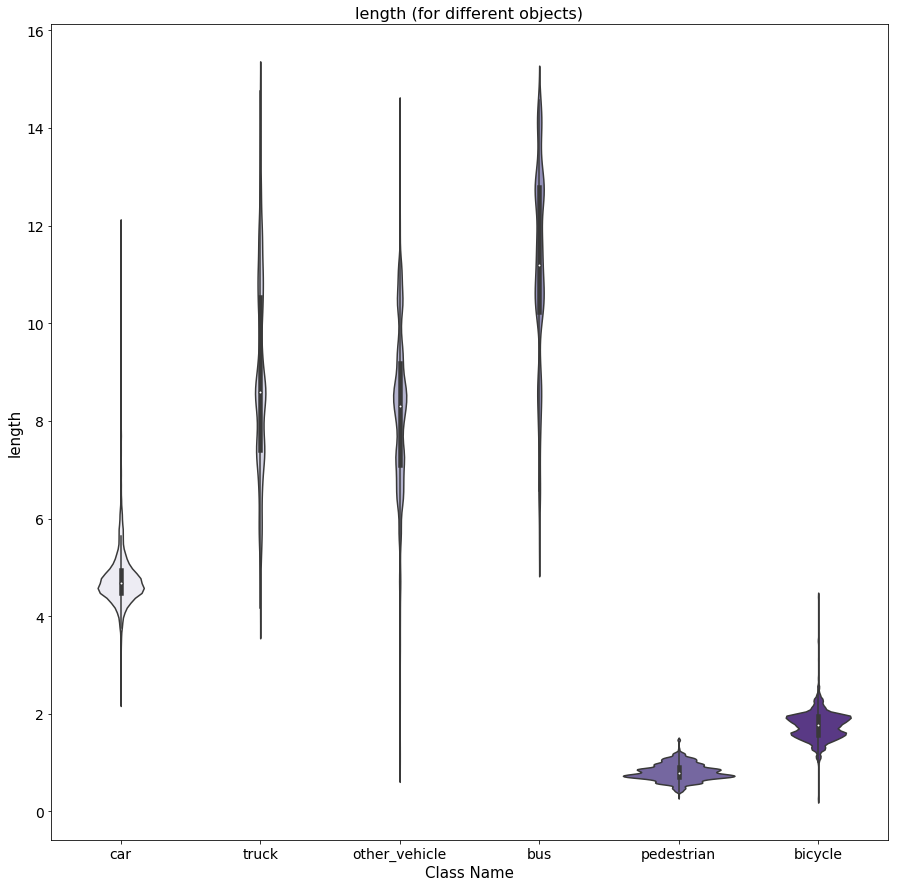

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="length",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and length < 15'),
                      palette='Purples',
                      split=True, ax=ax).set_title('length (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("length", fontsize=15)
plt.show(plot)

在小提琴图中，我们可以清楚地看到
- 与行人和自行车等小型物体相比，大型车辆（如汽车，公共汽车和卡车）的“长度”分布具有更大的均值。
- 因为卡车，公共汽车和汽车几乎总是比行人和自行车长得多。

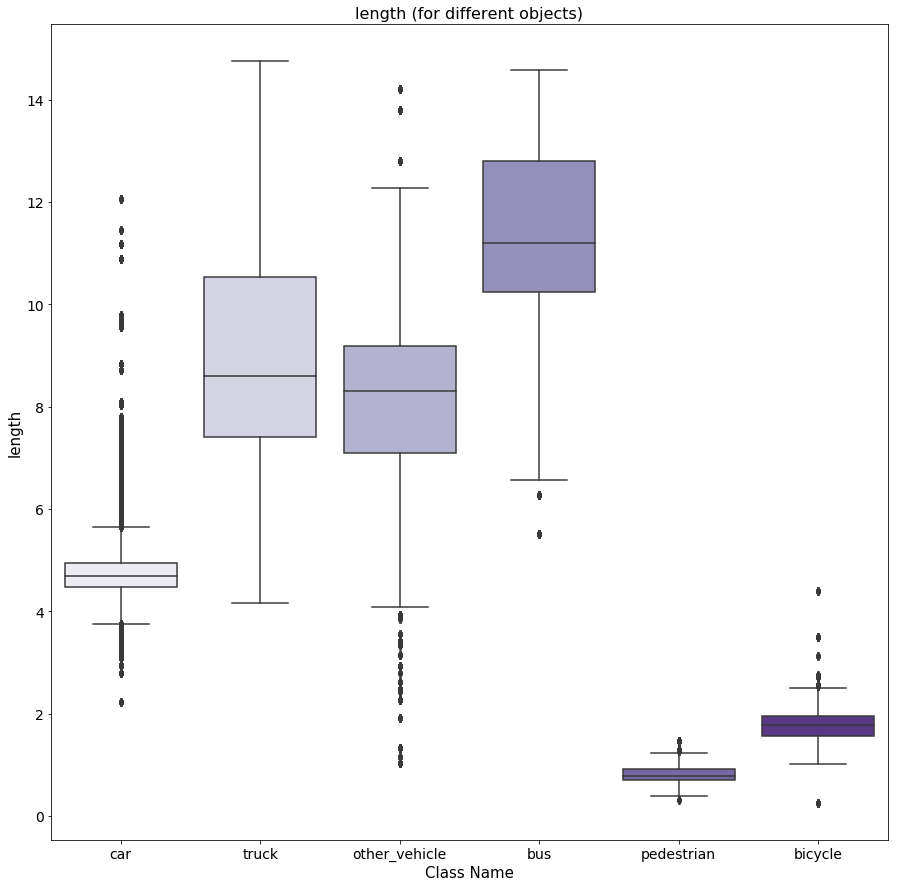

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="length",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and length < 15'),
                   palette='Purples', ax=ax).set_title('length (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("length", fontsize=15)
plt.show(plot)

在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。
- 与较大的物体（如汽车，卡车和公共汽车）相比，诸如行人和自行车之类的较小物体的“长度”分布的均值和四分位数值要小得多。

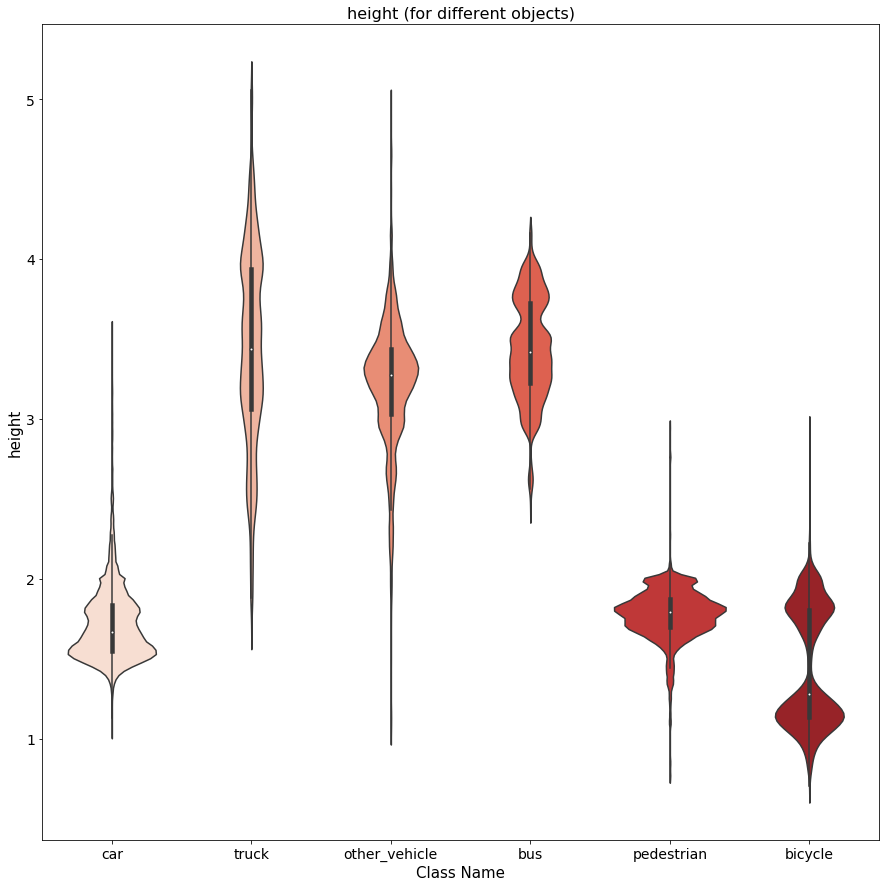

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x="class_name", y="height",
                      data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and height < 6'),
                      palette='Reds',
                      split=True, ax=ax).set_title('height (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("height", fontsize=15)
plt.show(plot)

在小提琴图中，我们可以清楚地看到
- 与行人和自行车等小型物体相比，大型车辆（如公共汽车和卡车）的“长度”分布具有更大的均值。 
- 因为卡车和公共汽车的长度几乎总是比行人和自行车的长度大得多。

这种趋势的唯一例外是汽车。 他们的身高往往与行人的身高相似。

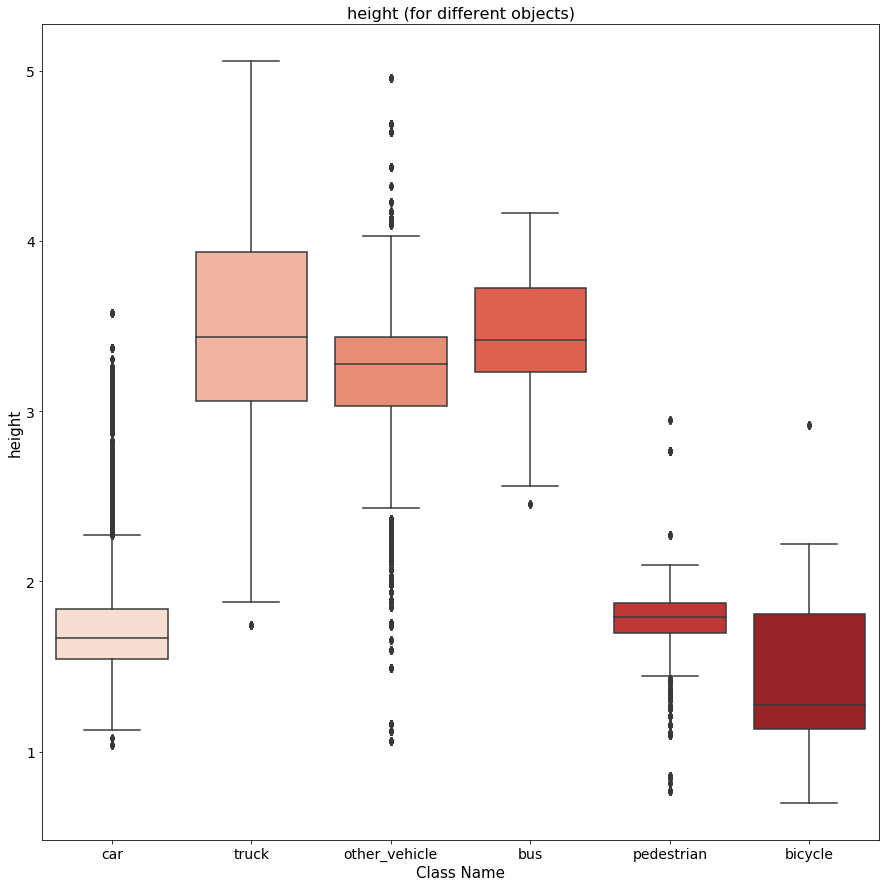

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="height",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and height < 6'),
                   palette='Reds', ax=ax).set_title('height (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("height", fontsize=15)
plt.show(plot)

在上面的方框图中，我们可以注意到与上面的小提琴图中相同的观察结果。
- 与较大的对象（如汽车，卡车和公共汽车）相比，行人和自行车等较小的对象的“高度”分布具有较小的均值和四分位值。

- 同样，这种趋势的唯一例外是汽车。 他们的身高往往与行人的身高相似。

In [34]:
lyft_dataset = LyftDataset(data_path=DATA_PATH, json_path=DATA_PATH+'train_data')

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 19.8 seconds.
Reverse indexing ...
Done reverse indexing in 7.1 seconds.


- 该数据集由多个场景组成，这些场景是自动驾驶汽车的LiDAR数据的25-45秒图像片段。
- 我们可以提取并查看第一个场景，如下所示：

In [35]:
my_scene = lyft_dataset.scene[0]
my_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

从上面可以看出，每个场景都包含一个信息字典。
- 每个场景都有一些令牌ID和name。 
- “name”与与给定场景关联的LiDAR数据文件的名称匹配。
- 此处，LiDAR文件的名称为：**host-a101-lidar0-1241893239199111666-1241893264098084346**。

In [36]:
def render_scene(index):
    my_scene = lyft_dataset.scene[index]
    my_sample_token = my_scene["first_sample_token"]
    lyft_dataset.render_sample(my_sample_token)

### 渲染第一个场景 (image and LiDAR)

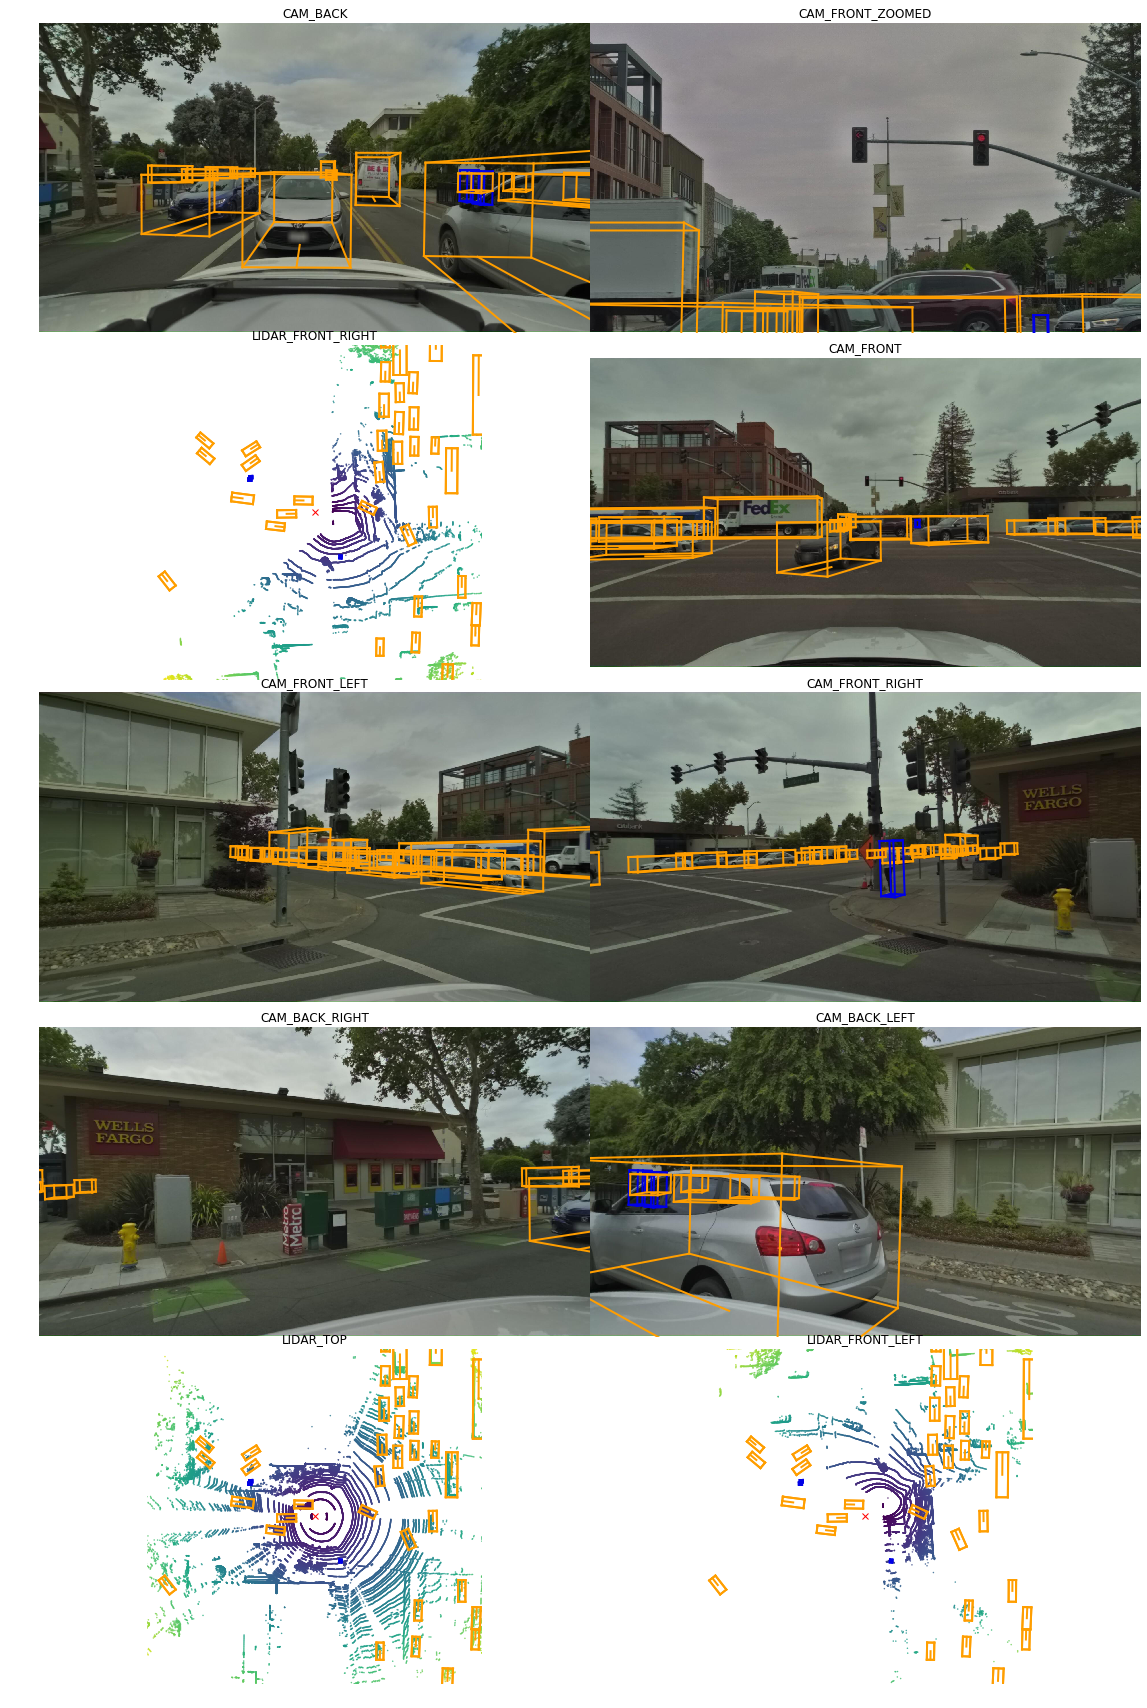

In [37]:
render_scene(0)

### 渲染第二个场景 (image and LiDAR)

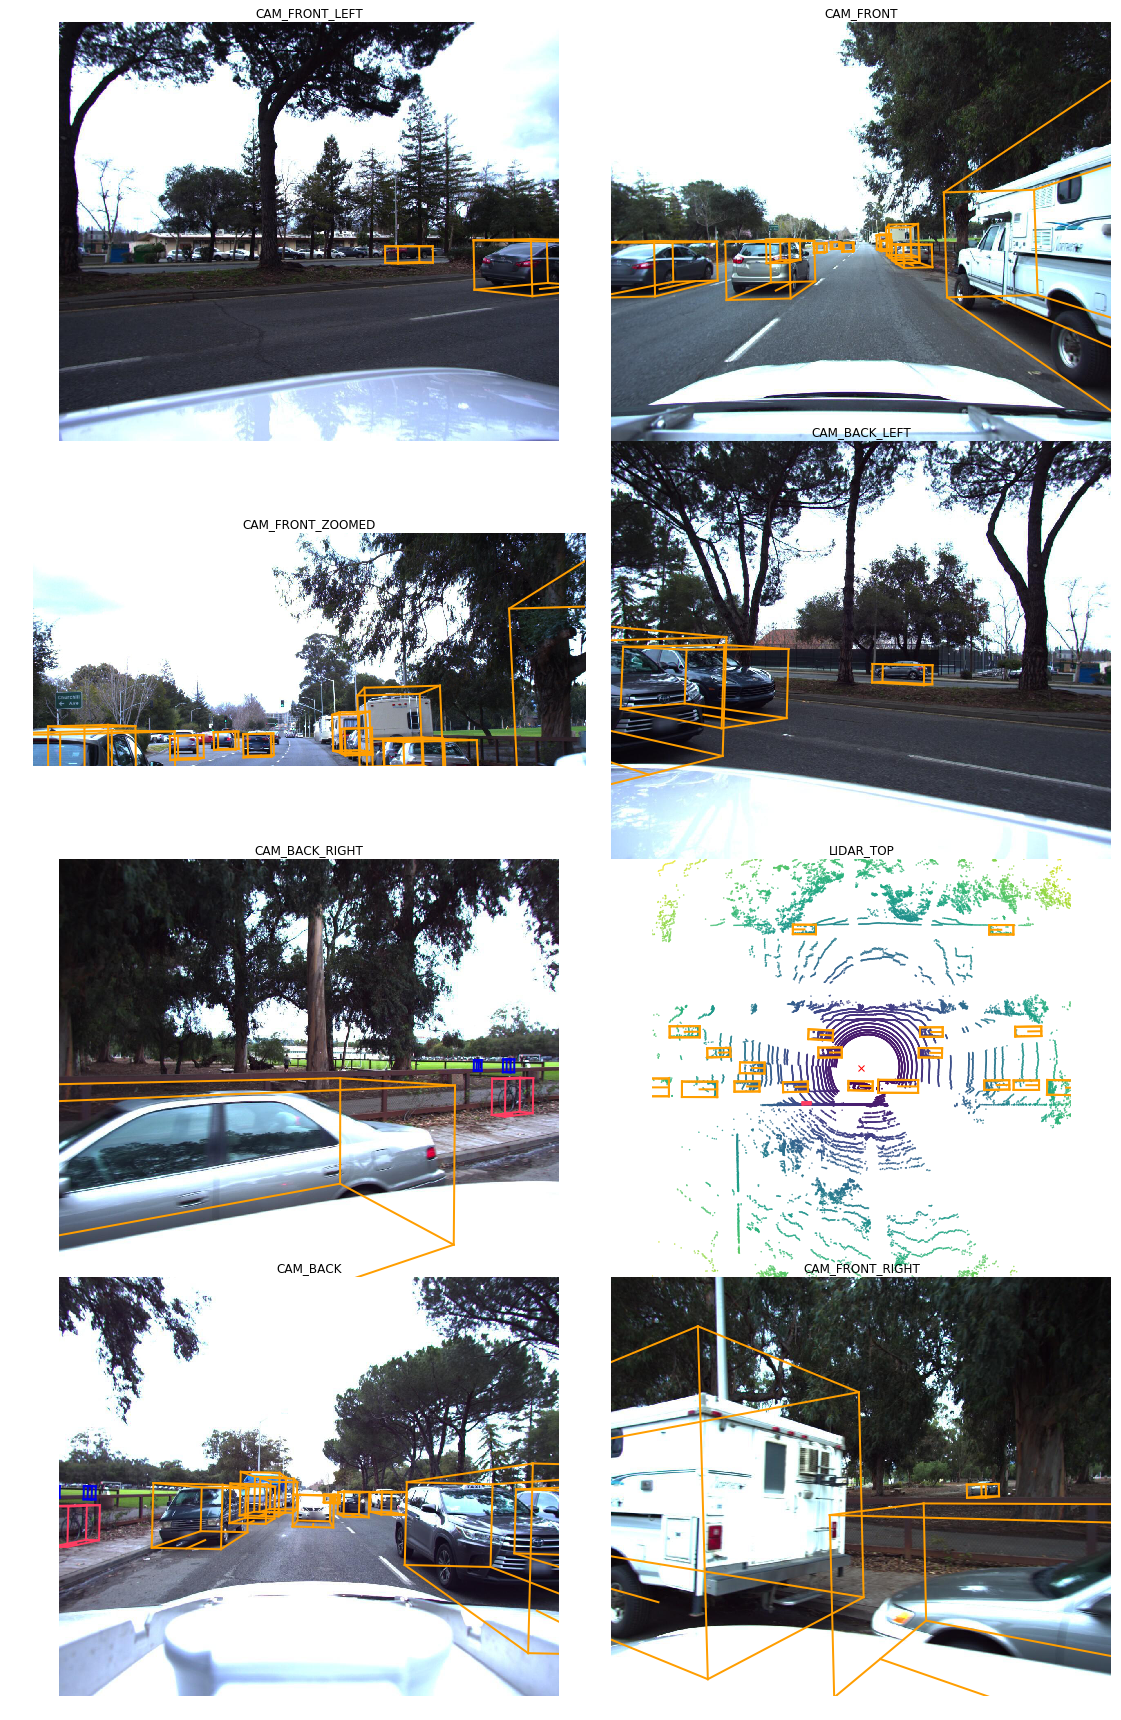

In [38]:
render_scene(1)

In [39]:
my_sample_token = my_scene["first_sample_token"]
my_sample = lyft_dataset.get('sample', my_sample_token)

### 前向摄像头可视化

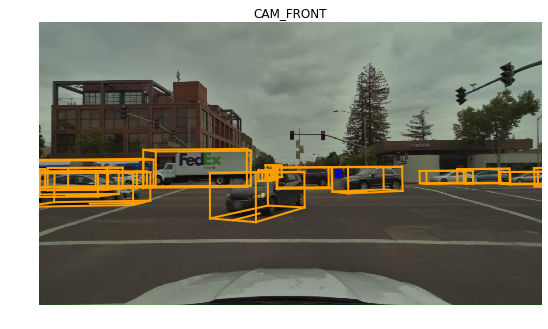

In [66]:
sensor_channel = 'CAM_FRONT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

### 后向摄像头可视化

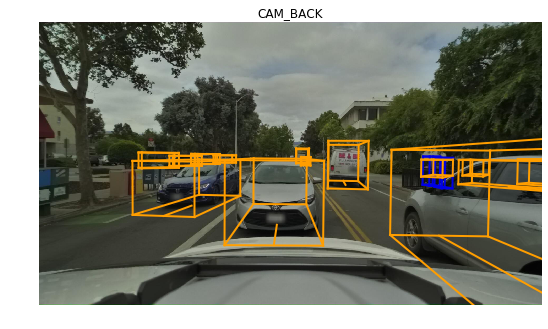

In [44]:
sensor_channel = 'CAM_BACK'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

### 左前方摄像头可视化

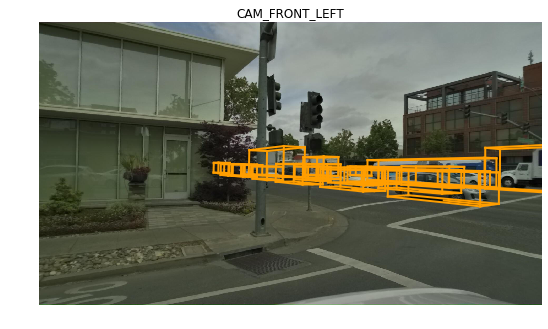

In [45]:
sensor_channel = 'CAM_FRONT_LEFT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

### 右前方摄像头可视化

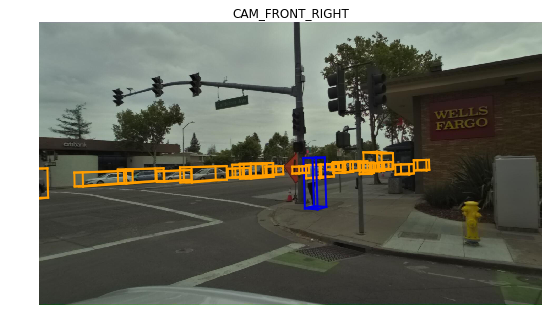

In [46]:
sensor_channel = 'CAM_FRONT_RIGHT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

### 左后方摄像头可视化

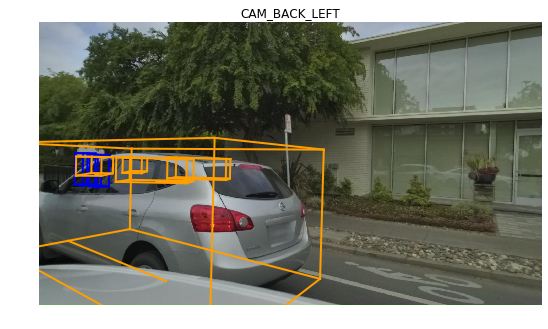

In [47]:
sensor_channel = 'CAM_BACK_LEFT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

### 右后方摄像头可视化

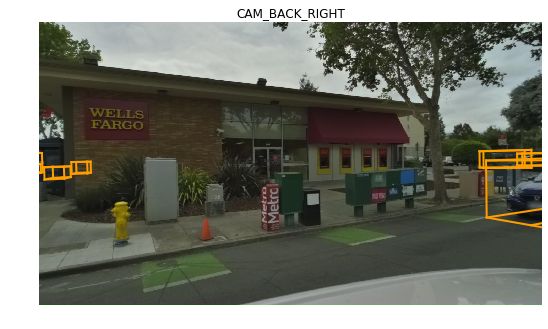

In [48]:
sensor_channel = 'CAM_BACK_RIGHT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])

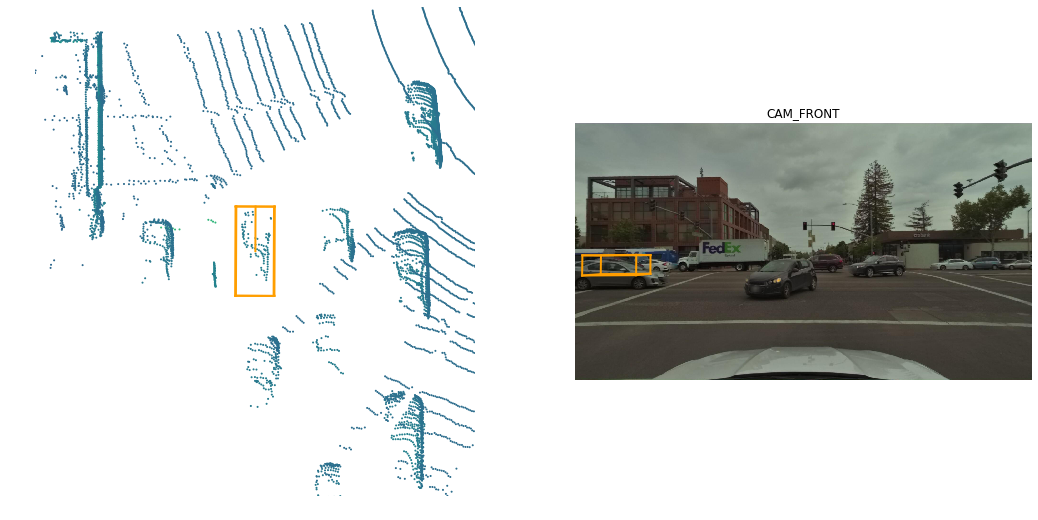

In [70]:
my_annotation_token = my_sample['anns'][10]
my_annotation =  my_sample_data.get('sample_annotation', my_annotation_token)
lyft_dataset.render_annotation(my_annotation_token)

In [71]:
my_instance = lyft_dataset.instance[100]

### 上方LiDAR

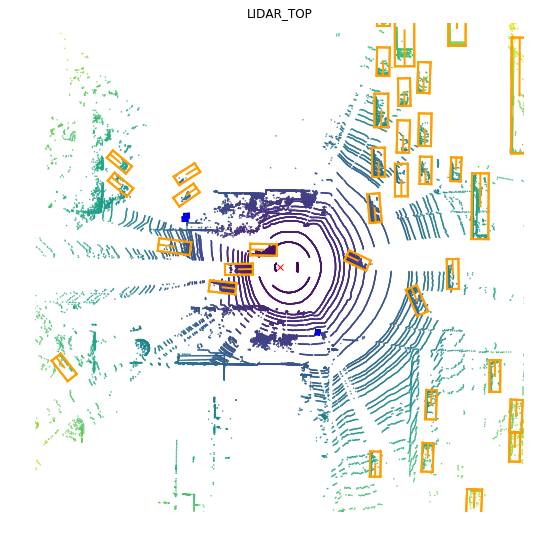

In [72]:
my_scene = lyft_dataset.scene[0]
my_sample_token = my_scene["first_sample_token"]
my_sample = lyft_dataset.get('sample', my_sample_token)
lyft_dataset.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5)

### 右前方 LiDAR 

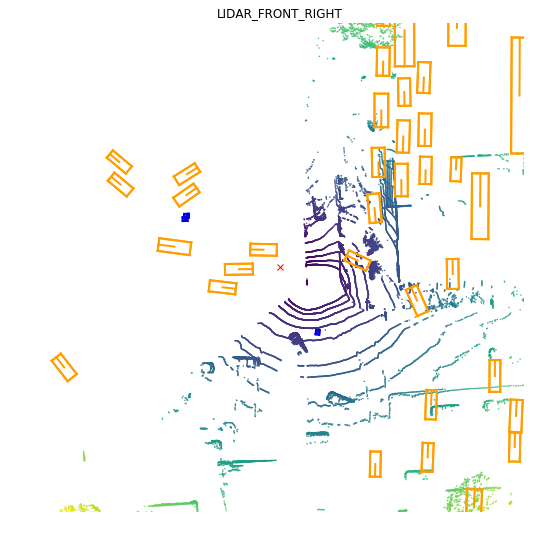

In [67]:
my_scene = lyft_dataset.scene[0]
my_sample_token = my_scene["first_sample_token"]
my_sample = lyft_dataset.get('sample', my_sample_token)
lyft_dataset.render_sample_data(my_sample['data']['LIDAR_FRONT_RIGHT'], nsweeps=5)